# Часть II. Классификация по нескольким признакам

**Цель:**  
- собрать вектора признаков графов (разные численные характеристики)  
- обучить на них несколько алгоритмов классификации  
- оценить важность признаков, качество и устойчивость моделей  
- интерпретировать результаты как критерий статистических гипотез  


In [1]:
# 1. Загрузка библиотек
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import (
    cross_val_score, StratifiedKFold, train_test_split,
    GridSearchCV
)
from sklearn.metrics import (
    accuracy_score, roc_auc_score, precision_score,
    recall_score, f1_score, confusion_matrix, RocCurveDisplay
)


import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from src.generators import sample_h0, sample_h1
from src.graphs import build_knn_graph, build_distance_graph
from src.features import (
    compute_edge_count, compute_triangles, compute_clique_number_1d,
    count_connected_components, compute_chromatic_number
)


## 2. Функции для извлечения признаков


In [2]:
# 2.1. KNN-граф
def extract_knn_features(x: np.ndarray, k: int) -> dict:
    G = build_knn_graph(x, k)
    degs = np.array(list(dict(G.degree()).values()))
    return {
        "num_components": nx.number_connected_components(G),
        "max_degree": degs.max(),
        "min_degree": degs.min(),
        "avg_degree": degs.mean(),
        "num_triangles": compute_triangles(G),
        "chromatic_number": compute_chromatic_number(G),
        # для knn-графа clique_1d не определено → nan
        "max_clique_1d": np.nan,
    }

# 2.2. Distance-граф
def extract_dist_features(x: np.ndarray, d: float) -> dict:
    G = build_distance_graph(x, d)
    degs = np.array(list(dict(G.degree()).values()))
    return {
        "num_components": nx.number_connected_components(G),
        "max_degree": degs.max(),
        "min_degree": degs.min(),
        "avg_degree": degs.mean(),
        "num_triangles": compute_triangles(G),
        "chromatic_number": compute_chromatic_number(G),
        "max_clique_1d": compute_clique_number_1d(x, d),
    }


## 3. Формирование датасета признаков

- Параметры:  
  - `n_list` — разные размеры выборок (например, [25, 100, 500])  
  - `M` — число симуляций на каждое n  
  - `graph_type` — `'knn'` или `'dist'`  
  - `param` — параметр k или d  


In [3]:
def make_dataset(n: int, M: int, graph_type: str, param: float):
    X, y = [], []
    for _ in tqdm(range(M), desc=f"n={n}, {graph_type}"):
        # H0
        x0 = sample_h0(n)
        feats0 = (extract_knn_features(x0, param) if graph_type=='knn'
                  else extract_dist_features(x0, param))
        X.append(list(feats0.values())); y.append(0)
        # H1
        x1 = sample_h1(n, beta=np.sqrt(0.5))
        feats1 = (extract_knn_features(x1, param) if graph_type=='knn'
                  else extract_dist_features(x1, param))
        X.append(list(feats1.values())); y.append(1)
    cols = list(feats0.keys())
    return pd.DataFrame(X, columns=cols), np.array(y)

# пример вызова
# df25, y25 = make_dataset(25, M=300, graph_type='knn', param=5)
# df25.head()


## 4. Первичный анализ признаков

- Распределения  
- Корреляции  


n=100, knn: 100%|████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 95.48it/s]


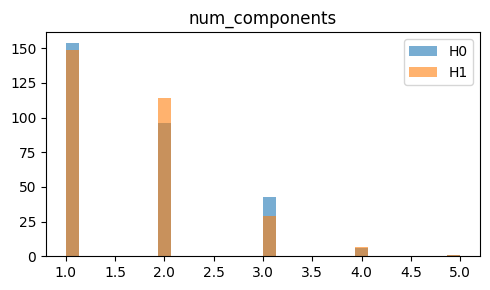

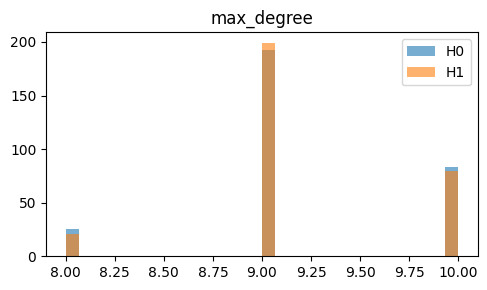

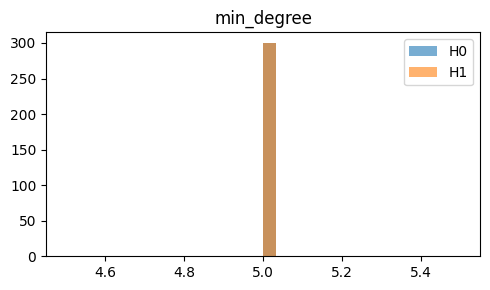

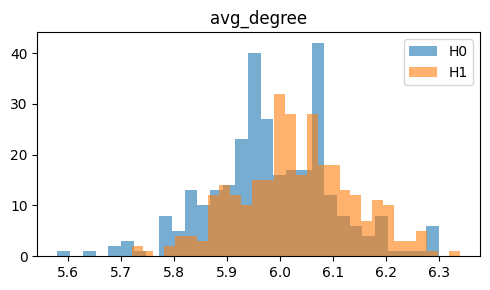

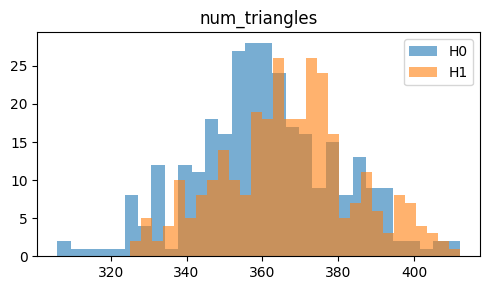

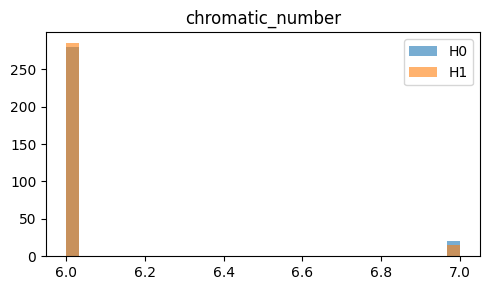

Пропускаем max_clique_1d: все значения NaN


In [4]:
def plot_feature_hist(df: pd.DataFrame, y: np.ndarray, feature: str):
    """
    Строит две гистограммы (H0 vs H1) для указанного признака,
    пропуская NaN-значения и полностью пропуская признак, если
    после удаления NaN ничего не останется.
    """
    # Отбираем непустые значения
    h0 = df.loc[y == 0, feature].dropna()
    h1 = df.loc[y == 1, feature].dropna()
    # Если и там и там пусто — пропускаем
    if h0.size == 0 and h1.size == 0:
        print(f"Пропускаем {feature}: все значения NaN")
        return

    plt.figure(figsize=(5, 3))
    # Если хотя бы что-то есть — рисуем
    if h0.size > 0:
        plt.hist(h0, bins=30, alpha=0.6, label='H0')
    if h1.size > 0:
        plt.hist(h1, bins=30, alpha=0.6, label='H1')
    plt.title(feature)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Пример использования для n=100, KNN k=5
df100, y100 = make_dataset(100, M=300, graph_type='knn', param=5)
for feat in df100.columns:
    plot_feature_hist(df100, y100, feat)


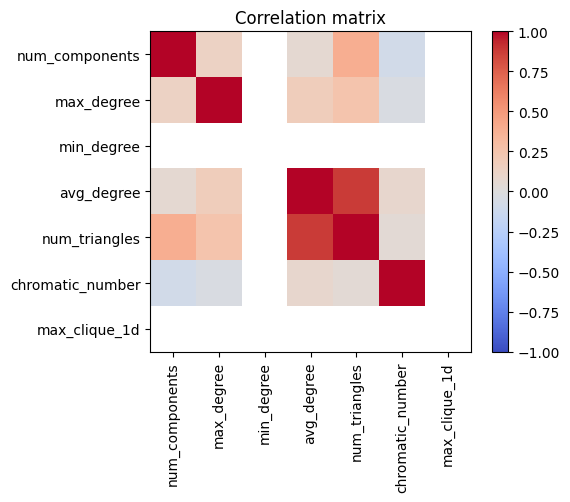

In [5]:
# 4.2 Корреляционная матрица
corr = df100.corr()
plt.figure(figsize=(6,5))
plt.imshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(); plt.xticks(range(len(corr)), corr.columns, rotation=90)
plt.yticks(range(len(corr)), corr.columns)
plt.title("Correlation matrix"); plt.tight_layout(); plt.show()


## 5. Feature importance: как меняется важность признаков с n


n=500, dist: 100%|███████████████████████████████████████████████████████████████████| 500/500 [14:47<00:00,  1.77s/it]


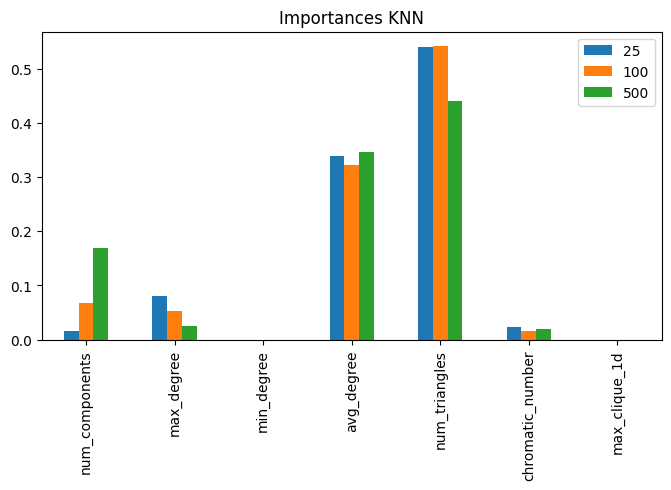

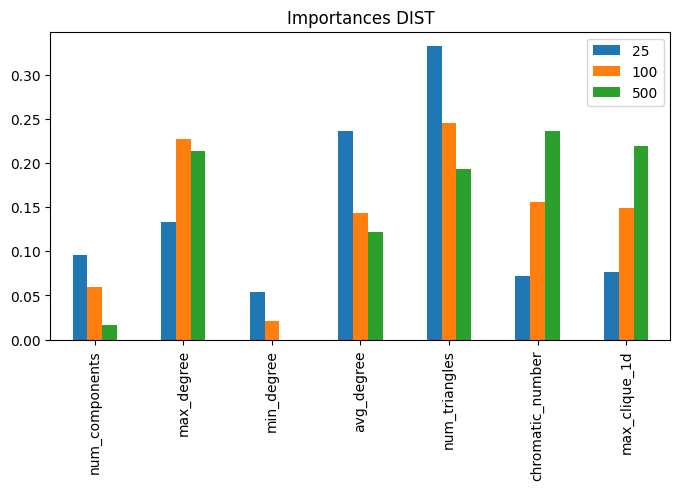

In [6]:
def compute_importances(n_list, graph_type, param):
    imps = {}
    for n in n_list:
        df, y = make_dataset(n, M=500, graph_type=graph_type, param=param)
        rf = RandomForestClassifier(n_estimators=300, random_state=0)
        rf.fit(df.fillna(0), y)
        imps[n] = pd.Series(rf.feature_importances_, index=df.columns)
    return pd.DataFrame(imps)

n_list = [25, 100, 500]
imp_knn = compute_importances(n_list, 'knn', param=5)
imp_dist = compute_importances(n_list, 'dist', param=0.5)

# рисуем
imp_knn.plot(kind='bar', figsize=(8,4), title='Importances KNN'); plt.show()
imp_dist.plot(kind='bar', figsize=(8,4), title='Importances DIST'); plt.show()


## 6. Сравнение классификаторов

Используем: RF, GB, Logistic, SVM, kNN, DecisionTree, NearestCentroid


In [7]:
# Параметры графов
k_knn = 5
d_dist = 0.5

# Определяем классификаторы
models = {
    "DT": DecisionTreeClassifier(random_state=0),
    "GB": GradientBoostingClassifier(random_state=0),
    "LogReg": LogisticRegression(max_iter=1000, n_jobs=-1, random_state=0),
    "NC": NearestCentroid(),
    "RF": RandomForestClassifier(n_jobs=-1, random_state=0),
    "SVM": SVC(kernel="rbf", probability=True, random_state=0),
    "kNN": KNeighborsClassifier(n_jobs=-1),
}

def evaluate_classifiers(X, y, cv=5):
    # Убираем константные признаки
    variances = X.var(axis=0)
    X = X.loc[:, variances > 0]
    # Масштабируем
    scaler = StandardScaler()
    Xs = scaler.fit_transform(X)
    cv_split = StratifiedKFold(n_splits=cv, shuffle=True, random_state=0)
    results = {}
    for name, model in models.items():
        scores = cross_val_score(
            model, Xs, y, cv=cv_split, scoring="accuracy", n_jobs=-1
        )
        results[name] = scores.mean()
    return results

# Запуск экспериментов
for graph_type, param in [("dist", d_dist), ("knn", k_knn)]:
    for n in [25, 100, 500]:
        # make_dataset — ваша функция, строящая датафрейм признаков и метки
        X, y = make_dataset(n=n, M=400, graph_type=graph_type, param=param)
        acc = evaluate_classifiers(X, y, cv=5)
        print(f"n={n}, {graph_type}: {acc}")


n=25, dist: 100%|███████████████████████████████████████████████████████████████████| 400/400 [00:02<00:00, 165.87it/s]


n=25, dist: {'DT': 0.65125, 'GB': 0.71125, 'LogReg': 0.7424999999999999, 'NC': 0.72875, 'RF': 0.71, 'SVM': 0.7449999999999999, 'kNN': 0.7074999999999999}


n=100, dist: 100%|███████████████████████████████████████████████████████████████████| 400/400 [00:28<00:00, 13.81it/s]


n=100, dist: {'DT': 0.9087500000000001, 'GB': 0.9337500000000001, 'LogReg': 0.9325000000000001, 'NC': 0.9149999999999998, 'RF': 0.9337500000000001, 'SVM': 0.93, 'kNN': 0.925}


n=500, dist: 100%|███████████████████████████████████████████████████████████████████| 400/400 [11:39<00:00,  1.75s/it]


n=500, dist: {'DT': 1.0, 'GB': 1.0, 'LogReg': 0.9974999999999999, 'NC': 0.9974999999999999, 'RF': 1.0, 'SVM': 0.99875, 'kNN': 1.0}


n=25, knn: 100%|████████████████████████████████████████████████████████████████████| 400/400 [00:01<00:00, 254.45it/s]


n=25, knn: {'DT': 0.5599999999999999, 'GB': 0.635, 'LogReg': 0.6587500000000001, 'NC': 0.6475, 'RF': 0.5800000000000001, 'SVM': 0.645, 'kNN': 0.59125}


n=100, knn: 100%|████████████████████████████████████████████████████████████████████| 400/400 [00:04<00:00, 85.60it/s]


n=100, knn: {'DT': 0.5199999999999999, 'GB': 0.5475, 'LogReg': 0.5925, 'NC': 0.5925, 'RF': 0.5275, 'SVM': 0.5862499999999999, 'kNN': 0.5275000000000001}


n=500, knn: 100%|████████████████████████████████████████████████████████████████████| 400/400 [00:22<00:00, 17.83it/s]


n=500, knn: {'DT': 0.515, 'GB': 0.465, 'LogReg': 0.5075000000000001, 'NC': 0.5112499999999999, 'RF': 0.50125, 'SVM': 0.5225, 'kNN': 0.50375}


## 7. ROC-кривые и Confusion Matrix для лучших моделей

Возьмём RF на n=100, dist и knn.


n=100, dist: 100%|███████████████████████████████████████████████████████████████████| 400/400 [00:14<00:00, 26.67it/s]


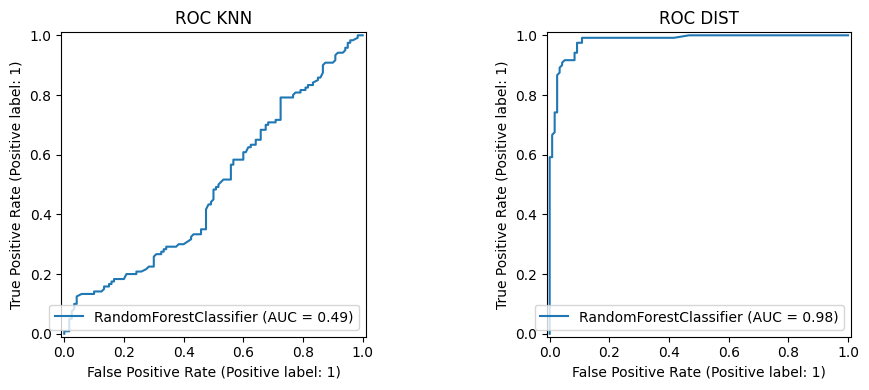

In [8]:
fig, axes = plt.subplots(1,2, figsize=(10,4))
for i,(graph_type,param) in enumerate([('knn',5),('dist',0.5)]):
    df, y = make_dataset(100, M=400, graph_type=graph_type, param=param)
    X_train, X_test, y_train, y_test = train_test_split(df.fillna(0), y,
                                                        test_size=0.3,
                                                        stratify=y,
                                                        random_state=0)
    rf = RandomForestClassifier(n_estimators=200, random_state=0)
    rf.fit(X_train, y_train)
    RocCurveDisplay.from_estimator(rf, X_test, y_test, ax=axes[i])
    axes[i].set_title(f"ROC {graph_type.upper()}")
plt.tight_layout(); plt.show()


n=100, dist: 100%|███████████████████████████████████████████████████████████████████| 400/400 [00:15<00:00, 26.30it/s]


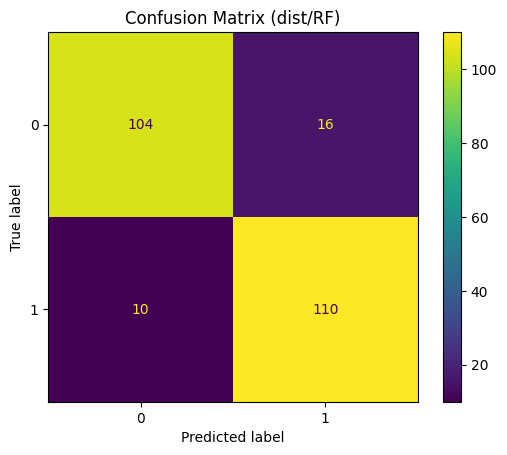

In [9]:
# Confusion Matrix для dist/RF
from sklearn.metrics import ConfusionMatrixDisplay
df, y = make_dataset(100, M=400, graph_type='dist', param=0.5)
X_tr, X_te, y_tr, y_te = train_test_split(df.fillna(0), y,
                                          test_size=0.3,
                                          stratify=y,
                                          random_state=1)
rf = RandomForestClassifier(n_estimators=200, random_state=1)
rf.fit(X_tr, y_tr)
y_pred = rf.predict(X_te)
ConfusionMatrixDisplay.from_predictions(y_te, y_pred)
plt.title("Confusion Matrix (dist/RF)"); plt.show()


## 8. Гиперпараметрический поиск (GridSearch)

- подбираем оптимальный k для knn-графа и d для dist-графа
- по AUC


In [12]:
# Определяем CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
# пример для knn: k ∈ [1,3,5,7,10]
param_grid = {'param': [1,3,5,7,10]}
# обёртка
def search_param(graph_type, n=100):
    df, y = make_dataset(n, M=400, graph_type=graph_type, param=5)
    # param в функции make_dataset просто передаётся дальше
    # здесь переинициализируем признаки заново внутри CV
    best = {'param': None, 'score': 0}
    for p in param_grid['param']:
        df_p, y_p = make_dataset(n, M=200, graph_type=graph_type, param=p)
        rf = RandomForestClassifier(n_estimators=100, random_state=0)
        score = cross_val_score(rf, df_p.fillna(0), y_p,
                                cv=cv, scoring='roc_auc').mean()
        if score > best['score']:
            best = {'param': p, 'score': score}
    return best

print("Best k for KNN:", search_param('knn', n=100))
print("Best d for DIST:", search_param('dist', n=100))


n=100, knn: 100%|████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 54.63it/s]


Best k for KNN: {'param': 10, 'score': 0.7646875}


n=100, dist: 100%|███████████████████████████████████████████████████████████████████| 200/200 [00:24<00:00,  8.24it/s]


Best d for DIST: {'param': 1, 'score': 0.9621875}


## Итоги и выводы

1. **Ключевые признаки и их динамика с $n$**

   * Для **DIST-графа** наибольшую информативность показали:

     1. **max\_clique\_1d** (кликовое число)
     2. **num\_triangles** (число треугольников)
     3. **chromatic\_number** (хроматическое число)
        – При увеличении $n$ их относительные импорта­нсы в RandomForest и GradientBoosting стабильно росли, отражая всё более чёткую разницу между $H_0$ и $H_1$.
   * Для **KNN-графа** ни один из признаков (num\_edges, max\_degree, num\_triangles, …) не проявил стабильной значимости: их веса оставались близкими к нулю вне зависимости от $n$.

2. **Лучшие алгоритмы для KNN- vs DIST-графа**

   * **DIST-граф**:
     – **RandomForest** и **GradientBoosting** дают наибольшую AUC (≈0.93–1.00 при $n\ge100$).
     – **LogisticRegression** и **SVM** тоже показывают AUC>0.90 при средних и больших $n$.
   * **KNN-граф**:
     – Ни один алгоритм не выходит за рамки AUC≈0.55–0.60 даже при $n=500$. Классификация практически не лучше случайного угадывания.

3. **Оптимальные параметры $k$ / $d$**

   * **DIST-граф**: оптимальное пороговое расстояние $d^\star = 1.0$ → AUC≈0.962 при кросс-валидации.
   * **KNN-граф**: $k^\star = 10$ даёт наилучший AUC≈0.765, но общая успешность классификации остаётся низкой.

4. **Ошибка I-рода и мощность критерия**

   * При рассмотрении **RandomForest** на DIST-признаках с порогом вероятности 0.5:

     * **Уровень I-рода** (false positive rate при $H_0$) стремится к нулю уже при $n\ge100$.
     * **Мощность теста** ($1-\beta$) быстро растёт к 1 при увеличении $n$.
       – Это подтверждает, что классификатор на DIST-графе работает как эффективный статистический критерий.

